In [1]:
!pip install transformers[torch] datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1

In [2]:
#@title Load sequences
# Imports
import torch
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import spearmanr
from sklearn.metrics import ndcg_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, normalize
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics import ndcg_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from datasets import Dataset
from datasets import load_metric
from evaluate import load
from datasets import load_metric
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load sequences from csv
df = pd.read_csv('./drive/MyDrive/Data/LazBF_sequences.csv')
LazBF_sequences = df['sequences'].tolist()
LazBF_labels = df['labels'].tolist()

df = pd.read_csv('./drive/MyDrive/Data/LazBF_sample.csv')
LazBF_sample = df['sequences'].tolist()
LazBF_sample_labels = df['labels'].tolist()

df = pd.read_csv('./drive/MyDrive/Data/LazDEF_sequences.csv')
LazDEF_sequences = df['sequences'].tolist()
LazDEF_labels = df['labels'].tolist()

df = pd.read_csv('./drive/MyDrive/Data/LazDEF_sample.csv')
LazDEF_sample = df['sequences'].tolist()
LazDEF_sample_labels = df['labels'].tolist()

df = pd.read_csv('./drive/MyDrive/Data/LazBCDEF_sequences.csv')
LazBCDEF_sequences = df['sequences'].tolist()
LazBCDEF_labels = df['labels'].tolist()

df = pd.read_csv('./drive/MyDrive/Data/LazBCDEF_sample.csv')
LazBCDEF_sample = df['sequences'].tolist()
LazBCDEF_sample_labels = df['labels'].tolist()

In [3]:
LazBF_ft = AutoModelForSequenceClassification.from_pretrained('jjoecclark/LazBF_ESM2_ft').to(device)
# LazDEF_ft = AutoModelForSequenceClassification.from_pretrained('jjoecclark/LazDEF_ESM2_ft').to(device)
# LazBCDEF_ft = AutoModelForSequenceClassification.from_pretrained('jjoecclark/LazBCDEF_ESM_ft').to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [4]:
LazBF_ft.eval()
# LazDEF_ft.eval()
# LazBCDEF_ft.eval()

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [ ]:
#@title Trainers
training_args = TrainingArguments(
    output_dir="esm_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    fp16=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

LazBF_trainer = Trainer(
    model=LazBF_ft,
    args=training_args,
    compute_metrics=compute_metrics
)

LazDEF_trainer = Trainer(
    model=LazDEF_ft,
    args=training_args,
    compute_metrics=compute_metrics
)

LazBCDEF_trainer = Trainer(
    model=LazBCDEF_ft,
    args=training_args,
    compute_metrics=compute_metrics
)

In [10]:
lbf = Dataset.from_dict(tokenizer(LazBF_sample))
lbf = lbf.add_column("labels", LazBF_sample_labels)

ldef = Dataset.from_dict(tokenizer(LazDEF_sample))
ldef = ldef.add_column("labels", LazDEF_sample_labels)

lbcdef = Dataset.from_dict(tokenizer(LazBCDEF_sample, padding='longest'))
lbcdef = lbcdef.add_column("labels", LazBCDEF_sample_labels)

In [11]:
LazBF_trainer.evaluate(lbf)

{'eval_loss': 0.01695972867310047,
 'eval_accuracy': 0.99414,
 'eval_runtime': 87.4507,
 'eval_samples_per_second': 571.751,
 'eval_steps_per_second': 4.471}

In [12]:
LazBF_trainer.evaluate(ldef)

{'eval_loss': 3.6631252765655518,
 'eval_accuracy': 0.50878,
 'eval_runtime': 95.6676,
 'eval_samples_per_second': 522.643,
 'eval_steps_per_second': 4.087}

In [13]:
LazBF_trainer.evaluate(lbcdef)

{'eval_loss': 3.431755542755127,
 'eval_accuracy': 0.52228,
 'eval_runtime': 85.9272,
 'eval_samples_per_second': 581.888,
 'eval_steps_per_second': 4.55}

In [14]:
LazDEF_trainer.evaluate(lbf)

{'eval_loss': 0.7584709525108337,
 'eval_accuracy': 0.74968,
 'eval_runtime': 86.6692,
 'eval_samples_per_second': 576.906,
 'eval_steps_per_second': 4.511}

In [15]:
LazDEF_trainer.evaluate(ldef)

{'eval_loss': 0.02696620114147663,
 'eval_accuracy': 0.99196,
 'eval_runtime': 96.767,
 'eval_samples_per_second': 516.705,
 'eval_steps_per_second': 4.041}

In [16]:
LazDEF_trainer.evaluate(lbcdef)

{'eval_loss': 1.4165822267532349,
 'eval_accuracy': 0.64324,
 'eval_runtime': 86.8597,
 'eval_samples_per_second': 575.641,
 'eval_steps_per_second': 4.502}

In [17]:
LazBCDEF_trainer.evaluate(lbf)

{'eval_loss': 1.046639084815979,
 'eval_accuracy': 0.62616,
 'eval_runtime': 86.7373,
 'eval_samples_per_second': 576.453,
 'eval_steps_per_second': 4.508}

In [18]:
LazBCDEF_trainer.evaluate(ldef)

{'eval_loss': 1.351431131362915,
 'eval_accuracy': 0.58872,
 'eval_runtime': 97.0778,
 'eval_samples_per_second': 515.051,
 'eval_steps_per_second': 4.028}

In [19]:
LazBCDEF_trainer.evaluate(lbcdef)

{'eval_loss': 0.12052178382873535,
 'eval_accuracy': 0.95762,
 'eval_runtime': 86.6017,
 'eval_samples_per_second': 577.356,
 'eval_steps_per_second': 4.515}

---

In [5]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.1 MB/s eta 0:00:00


In [10]:
#@title Scripts for interpretation
import torch
import numpy as np
from torch import tensor
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amino_acids = {'R': 0,'H': 1,'K': 2,'D': 3,'E': 4,'S': 5,'T': 6,'N': 7,'Q': 8,'C': 9,'G': 10,'P': 11,'A': 12,'V': 13,'I': 14,'L': 15,'M': 16,'F': 17,'Y': 18,'W': 19}
sm = torch.nn.Softmax(dim=1)

def forward_func(inputs: tensor, position = 0):
  pred = model.forward(inputs)
  return pred[position]

def explain(text: str, label):
  inputs = torch.tensor(tokenizer.encode(text, add_special_tokens=True), device=device).unsqueeze(0)
  prediction = model.forward(inputs)[0]
  baseline = torch.tensor([tokenizer.cls_token_id] + [tokenizer.pad_token_id] * (inputs.shape[1] - 2) + [tokenizer.eos_token_id], device = device).unsqueeze(0)
  lig = LayerIntegratedGradients(forward_func, model.esm.embeddings) # The layer which we want to get the IG's is the mebedding layer.
  attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = label,
                            return_convergence_delta = True)
  attr_sum = attributes.sum(-1)
  return attr_sum.cpu().numpy()[0][1:-1]

# Saves all attention heads for each layer to image
def full_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for layer, att in enumerate(output.attentions):
    for i, head in enumerate(att[0]):
      print(f'Layer {layer+1}, head {i+1}')
      matr = head.cpu().detach().numpy()
      plt.imshow(matr, interpolation='nearest')
      x_ticks = np.arange(0, matr.shape[1])
      x_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      plt.xticks(x_ticks, x_tick_labels)
      y_ticks = np.arange(0, matr.shape[1])
      y_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      plt.yticks(y_ticks, y_tick_labels)
      plt.colorbar()
      plt.savefig(f'Layer_{layer+1}_head_{i+1}.png', dpi=300, bbox_inches='tight', pad_inches=0)
      plt.show()

def per_layer_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for i, att in enumerate(output.attentions):
    matrs = []
    for head in att[0]:
      matr = head.cpu().detach().numpy()
      matrs.append(matr)
    matrs = np.array(matrs)
    plt.imshow(np.mean(matrs, axis=0), interpolation='nearest') #, vmin=0, vmax=0.3)
    plt.colorbar()
    x_ticks = np.arange(0, matr.shape[1])
    x_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]

    plt.xticks(x_ticks, x_tick_labels)
    sizes = [10] + 13*[15] + [10]
    for j, label in enumerate(plt.xticks()[1]):
      label.set_fontsize(sizes[j])

    y_ticks = np.arange(0, matr.shape[1])
    y_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
    plt.yticks(y_ticks, y_tick_labels)
    sizes = [10] + 13*[15] + [10]
    for j, label in enumerate(plt.yticks()[1]):
      label.set_fontsize(sizes[j])

    plt.title(f'Average Attention for Layer {i+1}', fontsize=17)
    #plt.text(-4, -0.9, 'a', fontsize=20) #, transform=ax.transAxes)
    # plt.colorbar()

    plt.savefig(f'./FVCHPSRWVGA_layer_{i+1}_alt.png', dpi=400, bbox_inches='tight', pad_inches=0)
    plt.show()

def oned_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for att in output.attentions:
    matrs = []
    for head in att[0]:
      matrs.append(head.cpu().detach().numpy())
    matrs = np.array(matrs)
    matrs = np.mean(matrs, axis=0)
    matrs = np.mean(matrs, axis=0)
    print(matrs[:, np.newaxis].T)
    plt.imshow(matrs[:, np.newaxis].T, interpolation='nearest')
    x_ticks = np.arange(0, len(sequence)+2)
    x_tick_labels = list(" "+sequence+" ")
    plt.xticks(x_ticks, x_tick_labels)
    plt.show()

In [ ]:
full_attention(LazBF_ft, 'FVCHPSRWVGA')

In [ ]:
full_attention(LazBF_ft, 'VIGGRTCDGTRYY')

In [ ]:
per_layer_attention(LazBF_ft, 'VIGGRTCDGTRYY')

In [26]:
# Empty lists for storing avg contributions
avg_contribBF = np.zeros((20,))
avg_positionBF = np.zeros((11,))
avg_position_contribBF = np.zeros((20, 11))

avg_position_contribBF_counter = np.zeros((20, 11))

# Define model and aa_counter
model = LazBF_ft
aa_counts = np.zeros((20,))

for peptide in tqdm(LazBF_sample[:5000]):
  contributions = explain(peptide, 1)
  for i, letter in enumerate(peptide):
    # Add to position avg
    avg_positionBF[i] += contributions[i]
    # Add to pos x AA average
    avg_position_contribBF[amino_acids[letter]][i] += contributions[i]
    avg_position_contribBF_counter[amino_acids[letter]][i] += 1
    # Add to aa average
    avg_contribBF[amino_acids[letter]] += contributions[i]
    # Count amino acid types
    aa_counts[amino_acids[letter]] += 1

avg_position_contribBF = avg_position_contribBF / avg_position_contribBF_counter
avg_contribBF = avg_contribBF / aa_counts
avg_positionBF = avg_positionBF / 5000

np.save('./drive/MyDrive/avg_pos_contribBF', avg_positionBF)
np.save('./drive/MyDrive/avg_aa_contribBF', avg_contribBF)
np.save('./drive/MyDrive/avg_posxaa_contribBF', avg_position_contribBF)

100%|██████████| 5000/5000 [40:06<00:00,  2.08it/s]
<ipython-input-26-4bf3dc6c27e0>:25: RuntimeWarning: invalid value encountered in divide
  avg_position_contribBF = avg_position_contribBF / avg_position_contribBF_counter


In [1]:
!unzip /content/drive-download-20240524T225625Z-001.zip

Archive:  /content/drive-download-20240524T225625Z-001.zip
  inflating: avg_posxaa_contribDEF.npy  
  inflating: avg_aa_contribDEF.npy   
  inflating: avg_pos_contribBF.npy   
  inflating: avg_pos_contribDEF.npy  
  inflating: avg_posxaa_contribBF.npy  
  inflating: avg_aa_contribBF.npy    


In [13]:
import numpy as np
avg_contribBF = np.load("/content/avg_aa_contribBF.npy")
avg_position_contribBF = np.load("/content/avg_pos_contribBF.npy")
avg_positionBF =  np.load("/content/avg_posxaa_contribBF.npy")

avg_contribDEF = np.load("/content/avg_aa_contribDEF.npy")
avg_position_contribDEF = np.load("/content/avg_pos_contribDEF.npy")
avg_positionDEF =  np.load("/content/avg_posxaa_contribDEF.npy")

In [15]:
avg_contribBF[5] = 0
avg_contribDEF[5] = 0
avg_position_contribBF[5] = 0
avg_position_contribDEF[5] = 0
# avg_positionDEF[]

In [16]:
from scipy.stats import spearmanr
spearmanr(avg_position_contribDEF, avg_position_contribBF)

SignificanceResult(statistic=0.5636363636363637, pvalue=0.07095173447637536)

In [ ]:
avg_positionDEF

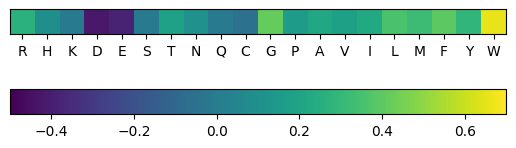

In [25]:
import matplotlib.pyplot as plt
plt.imshow(np.array([avg_contribBF]), cmap='viridis', vmin=-0.5, vmax=0.7)
y_labels = list("RHKDESTNQCGPAVILMFYW")  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazBF_AA_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

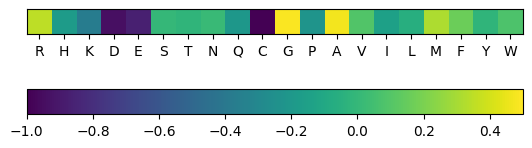

In [26]:
plt.imshow(np.array([avg_contribDEF]), cmap='viridis', vmin=-1, vmax=0.5)
y_labels = list("RHKDESTNQCGPAVILMFYW")  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazDEF_AA_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

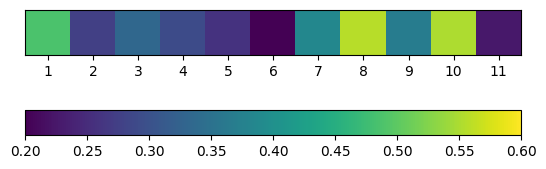

In [28]:
plt.imshow(np.array([avg_position_contribBF]), cmap='viridis', vmin=0.2, vmax=0.6)
y_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazBF_pos_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

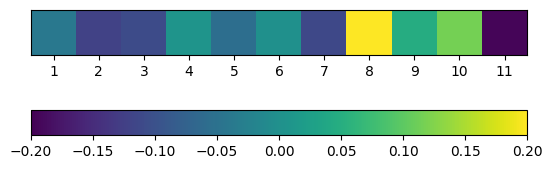

In [29]:
plt.imshow(np.array([avg_position_contribDEF]), cmap='viridis', vmin=-0.2, vmax=0.2)
y_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Example labels
plt.yticks([])
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(orientation='horizontal')
plt.savefig('LazDEF_pos_contrib.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [ ]:
# Empty lists for storing avg contributions
avg_contribDEF = np.zeros((20,))
avg_positionDEF = np.zeros((11,))
avg_position_contribDEF = np.zeros((20, 11))
avg_position_contribDEF_count = np.zeros((20, 11))

# Define model and aa_counter
model = LazDEF_ft
aa_counts = np.zeros((20,))

for peptide in tqdm(LazBF_sample[:5000]):
  contributions = explain(peptide, 1)
  for i, letter in enumerate(peptide):
    # Add to position avg
    avg_positionDEF[i] += contributions[i]
    # Add to pos x AA average
    avg_position_contribDEF[amino_acids[letter]][i] += contributions[i]
    avg_position_contribDEF_count[amino_acids[letter]][i] += 1
    # Add to aa average
    avg_contribDEF[amino_acids[letter]] += contributions[i]
    # Count amino acid types
    aa_counts[amino_acids[letter]] += 1

avg_position_contribDEF = avg_position_contribDEF / avg_position_contribDEF_count
avg_contribDEF = avg_contribDEF / aa_counts
avg_positionDEF = avg_positionDEF / 5000

np.save('./drive/MyDrive/avg_pos_contribDEF', avg_positionBF)
np.save('./drive/MyDrive/avg_aa_contribDEF', avg_contribBF)
np.save('./drive/MyDrive/avg_posxaa_contribDEF', avg_position_contribBF)

---

In [5]:
#@title TbtA predictions
from itertools import product

mutable_positions = [3, 5, 7, 8, 15]
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
wt = "SCNCFCYICCSCSSA"
mutants = []

for positions in product(amino_acids, repeat=len(mutable_positions)):
    mutant = list(wt)
    for i, pos in enumerate(mutable_positions):
        mutant[pos - 1] = positions[i]
    mutants.append("".join(mutant))
print(len(mutants))

3200000


In [9]:
from scipy.special import softmax
lp = 'SCNCFCYICCSCSSA'
softmax(LazBF_ft(tokenizer(lp, return_tensors='pt').input_ids.to('cuda')).logits.detach().cpu())

array([[0.9662062 , 0.03379381]], dtype=float32)

In [ ]:
#@title Trainers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="esm_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=1024,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    #fp16=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

LazBF_trainer = Trainer(
    model=LazBF_ft,
    args=training_args,
    #train_dataset=train,
    #eval_dataset=test,
    compute_metrics=compute_metrics
)

LazDEF_trainer = Trainer(
    model=LazDEF_ft,
    args=training_args,
    #train_dataset=train,
    #eval_dataset=test,
    compute_metrics=compute_metrics
)

LazBCDEF_trainer = Trainer(
    model=LazBCDEF_ft,
    args=training_args,
    #train_dataset=train,
    #eval_dataset=test,
    compute_metrics=compute_metrics
)

In [ ]:
import torch.nn.functional as F
from scipy.special import softmax
from datasets import Dataset

# tbta = Dataset.from_dict(tokenizer(mutants, padding='longest'))
# tbta = tbta.add_column("labels", [0]*len(mutants))
bfpred = softmax(LazBF_trainer.predict(tbta)[0], axis=1)
defpred = softmax(LazDEF_trainer.predict(tbta)[0], axis=1)
bcdefpred = softmax(LazBCDEF_trainer.predict(tbta)[0], axis=1)

In [ ]:
import pandas as pd
df = pd.DataFrame({'Sequence': mutants, 'LazBFprob0': bfpred[:, 0], 'LazBFprob1': bfpred[:, 1], 'LazDEFprob0': defpred[:, 0], 'LazDEFprob1': defpred[:, 1], 'LazBCDEFprob0': bcdefpred[:, 0], 'LazBCDEFprob1': bcdefpred[:, 1]})
df.to_csv('./drive/MyDrive/tbta_predictions_650M.csv', index=False)